In [19]:
import pandas as pd
import numpy as np
import xgboost as xgb
import shap
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import RFE
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from statsmodels.stats.outliers_influence import variance_inflation_factor
import eli5
from eli5.sklearn import PermutationImportance
from operator import itemgetter

import warnings
warnings.filterwarnings("ignore")

In [60]:
df = pd.read_csv('Updated_frame_2.csv')

In [61]:
cat_cols = [col for col in df.columns if df[col].dtypes == 'object']
cat_cols

['Location_type',
 'zone',
 'WH_regional_zone',
 'Ware_house_ID',
 'WH_Manager_ID',
 'WH_capacity_size',
 'wh_owner_type',
 'approved_wh_govt_certificate']

In [62]:
for col in cat_cols:
    le = LabelEncoder()
    df.loc[:, col] = le.fit_transform(df[col])

In [63]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25000 entries, 0 to 24999
Data columns (total 27 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Location_type                 25000 non-null  int32  
 1   zone                          25000 non-null  int32  
 2   WH_regional_zone              25000 non-null  int32  
 3   num_refill_req_l3m            25000 non-null  int64  
 4   Competitor_in_mkt             25000 non-null  int64  
 5   Comp_Ref_Ratio                25000 non-null  float64
 6   Ware_house_ID                 25000 non-null  int32  
 7   WH_Manager_ID                 25000 non-null  int32  
 8   WH_capacity_size              25000 non-null  int32  
 9   transport_issue_l1y           25000 non-null  int64  
 10  retail_shop_num               25000 non-null  int64  
 11  wh_owner_type                 25000 non-null  int32  
 12  distributor_num               25000 non-null  int64  
 13  f

In [64]:
num_cols = [col for col in df.columns if df[col].dtypes in ['int64', 'float64', 'int32'] and col not in ['product_wg_ton']]

In [65]:
for col in num_cols:
    scaler = StandardScaler()
    df.loc[:, col] = scaler.fit_transform(df[col].values.reshape(-1, 1))

In [66]:
df

,Location_type,zone,WH_regional_zone,num_refill_req_l3m,Competitor_in_mkt,Comp_Ref_Ratio,Ware_house_ID,WH_Manager_ID,WH_capacity_size,transport_issue_l1y,...,workers_num,wh_est_year,storage_issue_reported_l3m,temp_reg_mach,approved_wh_govt_certificate,wh_breakdown_l3m,govt_check_l3m,product_wg_ton,Prop_Demand_E_Pk,age
0,-0.298316,-2.118629,-1.949253,0.733135,2.536526,0.064801,0.955746,0.955746,1.632547,0.188690,...,0.642196,-0.050902,0.313239,1.515679,-0.798169,-0.285180,-0.325789,25139,5.055643,0.050902
1,-0.298316,-2.118629,-1.949253,0.733135,2.536526,0.064801,1.318783,1.318783,1.632547,0.188690,...,-1.390229,NaN,-0.341717,-0.659770,0.527253,1.489652,-0.325789,16088,5.055643,NaN
2,-0.298316,-2.118629,-1.949253,0.733135,-0.091272,0.168861,0.360474,0.360474,1.632547,-0.645043,...,-0.882123,NaN,-1.433309,1.515679,1.189964,-0.285180,1.411889,5060,5.055643,NaN
3,-0.298316,-2.118629,-1.949253,0.733135,0.784661,0.168861,-1.175370,-1.175370,1.632547,-0.645043,...,NaN,1.410321,-0.996672,-0.659770,0.527253,-0.876791,1.411889,9131,5.055643,-1.410321
4,-0.298316,-2.118629,-1.949253,0.733135,1.660593,0.259914,-1.283865,-1.283865,1.632547,-0.645043,...,1.404355,0.214775,0.204080,-0.659770,0.527253,-0.876791,1.411889,22130,5.055643,-0.214775
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24995,3.352150,1.276973,1.047901,-0.801455,-0.967205,-0.121921,-0.478808,-0.478808,-1.056278,1.022424,...,0.134089,NaN,0.313239,-0.659770,-1.460880,0.898041,-1.484241,25145,-2.911823,NaN
24996,3.352150,1.276973,1.047901,-0.801455,-0.967205,-0.121921,-0.140712,-0.140712,-1.056278,1.022424,...,0.515169,NaN,0.531558,-0.659770,-1.460880,-0.285180,0.485127,29118,-2.911823,NaN
24997,3.352150,1.276973,1.047901,-0.801455,-0.967205,-0.121921,0.141266,0.141266,-1.056278,-0.645043,...,-0.882123,NaN,1.295673,-0.659770,0.527253,-0.285180,-1.484241,35073,-2.911823,NaN
24998,3.352150,1.276973,1.047901,-0.801455,-0.967205,-0.121921,0.764250,0.764250,-1.056278,-0.645043,...,1.023275,NaN,0.968195,-0.659770,0.527253,-0.285180,0.485127,33070,-2.911823,NaN


In [67]:
df.drop(['WH_Manager_ID', 'Ware_house_ID', 'age', 'wh_est_year'], axis=1, inplace=True)

In [68]:
df.dropna(axis=0, inplace=True)

In [44]:
X = df.drop('product_wg_ton', axis=1)
X = sm.add_constant(X)
y = df['product_wg_ton']

In [45]:
model = sm.OLS(y, X)
res = model.fit()

In [46]:
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:         product_wg_ton   R-squared:                       0.977
Model:                            OLS   Adj. R-squared:                  0.977
Method:                 Least Squares   F-statistic:                 4.644e+04
Date:                Fri, 10 Mar 2023   Prob (F-statistic):               0.00
Time:                        20:03:51   Log-Likelihood:            -2.1348e+05
No. Observations:               24010   AIC:                         4.270e+05
Df Residuals:                   23987   BIC:                         4.272e+05
Df Model:                          22                                         
Covariance Type:            nonrobust                                         
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
const           

In [47]:
vif = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif_frame = pd.DataFrame({'vif': vif}, index=X.columns)

In [48]:
np.round(vif_frame['vif'], 2)

const                           1.00
Location_type                   1.03
zone                            1.07
WH_regional_zone                1.40
num_refill_req_l3m              1.09
Competitor_in_mkt               1.10
Comp_Ref_Ratio                  1.05
WH_capacity_size                1.40
transport_issue_l1y             1.03
retail_shop_num                 1.04
wh_owner_type                   1.08
distributor_num                 1.00
flood_impacted                  1.06
flood_proof                     1.02
electric_supply                 1.19
dist_from_hub                   1.00
workers_num                     1.16
storage_issue_reported_l3m      1.24
temp_reg_mach                   1.11
approved_wh_govt_certificate    1.10
wh_breakdown_l3m                1.19
govt_check_l3m                  1.13
Prop_Demand_E_Pk                1.05
Name: vif, dtype: float64

In [49]:
#X = df.drop('product_wg_ton', axis=1)
#y = df['product_wg_ton']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

lin_reg = LinearRegression()
lin_reg.fit(X_train, y_train)
y_pred = lin_reg.predict(X_test)
score = r2_score(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred, squared=False)
mae = mean_absolute_error(y_test, y_pred)
print(rmse)
print(score)
print(mae)

1733.3039228204238
0.9774975845728896
1290.0810770055862


In [50]:
perm = PermutationImportance(lin_reg, random_state=42).fit(X_train, y_train)
eli5.show_weights(perm, feature_names=X.columns.tolist())

Weight,Feature
1.9572 ± 0.0233,storage_issue_reported_l3m
0.0028 ± 0.0001,temp_reg_mach
0.0024 ± 0.0001,wh_breakdown_l3m
0.0019 ± 0.0001,transport_issue_l1y
0.0000 ± 0.0000,approved_wh_govt_certificate
0.0000 ± 0.0000,Location_type
0.0000 ± 0.0000,distributor_num
0.0000 ± 0.0000,flood_proof
0.0000 ± 0.0000,govt_check_l3m
0.0000 ± 0.0000,zone


In [51]:
k_explainer = shap.KernelExplainer(lin_reg.predict, shap.sample(X_train, 100))

In [52]:
shap_values = k_explainer.shap_values(X_test, nsamples=100)

  0%|          | 0/4802 [00:00<?, ?it/s]

In [53]:
shap.initjs()
shap.force_plot(k_explainer.expected_value, shap_values[0], np.array(X_test)[0])

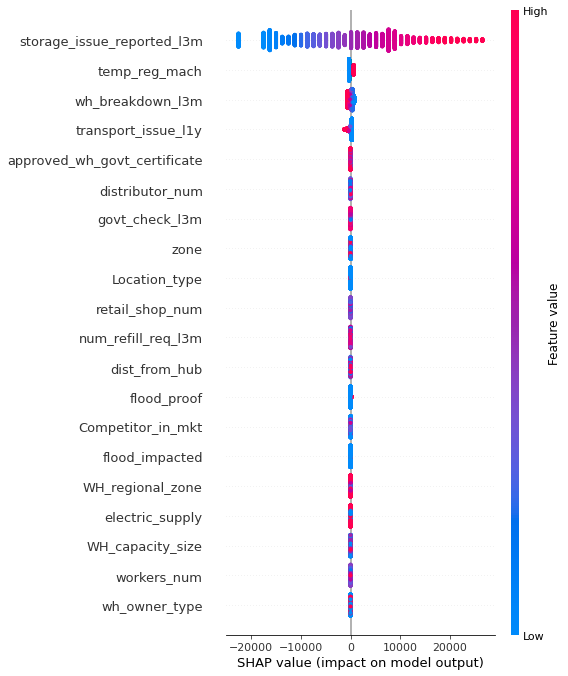

In [54]:
shap.summary_plot(shap_values, X_test)

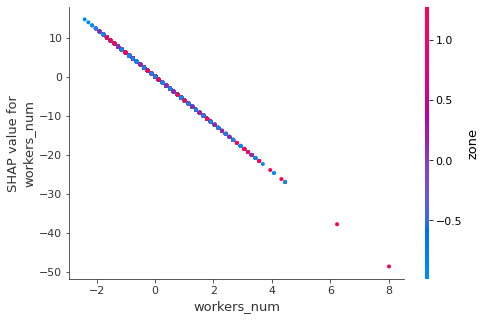

In [56]:
shap.dependence_plot('workers_num', shap_values, X_test, interaction_index='zone')

In [57]:
n_features_to_select = 0.5
rfe = RFE(lin_reg, n_features_to_select=n_features_to_select)
rfe.fit(X_train, y_train)

RFE(estimator=LinearRegression(), n_features_to_select=0.5)

In [58]:
features = X_train.columns.to_list()
for x, y in (sorted(zip(rfe.ranking_ , features), key=itemgetter(0))):
    print(x, y)
    
predictions = rfe.predict(X_test)
print(predictions)

1 Location_type
1 zone
1 transport_issue_l1y
1 retail_shop_num
1 distributor_num
1 flood_proof
1 storage_issue_reported_l3m
1 temp_reg_mach
1 approved_wh_govt_certificate
1 wh_breakdown_l3m
1 govt_check_l3m
2 num_refill_req_l3m
3 dist_from_hub
4 WH_regional_zone
5 flood_impacted
6 Competitor_in_mkt
7 workers_num
8 WH_capacity_size
9 electric_supply
10 wh_owner_type
11 Prop_Demand_E_Pk
12 Comp_Ref_Ratio
13 const
[ 8332.4418523  38684.507264   40741.19714717 ...  7266.18893715
 25405.00769018 43233.81727897]


In [69]:
X = df.drop('product_wg_ton', axis=1)
y = df['product_wg_ton']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

xgboost = xgb.XGBRegressor(eta=0.1)
xgboost.fit(X_train, y_train)
y_pred = xgboost.predict(X_test)
score = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred, squared=False)
mae = mean_absolute_error(y_test, y_pred)
print(mse)
print(rmse)
print(score)
print(mae)

826790.1304882346
909.2800066471464
0.9938073721434098
681.8672818617243


In [70]:
perm = PermutationImportance(xgboost, random_state=1).fit(X_train, y_train)
eli5.show_weights(perm, feature_names=X.columns.tolist())

Weight,Feature
1.9510 ± 0.0323,storage_issue_reported_l3m
0.0160 ± 0.0004,approved_wh_govt_certificate
0.0025 ± 0.0001,transport_issue_l1y
0.0021 ± 0.0001,temp_reg_mach
0.0007 ± 0.0001,num_refill_req_l3m
0.0004 ± 0.0000,retail_shop_num
0.0003 ± 0.0000,Comp_Ref_Ratio
0.0002 ± 0.0000,dist_from_hub
0.0002 ± 0.0000,distributor_num
0.0002 ± 0.0000,Prop_Demand_E_Pk
